Number of images used for calibration:  41


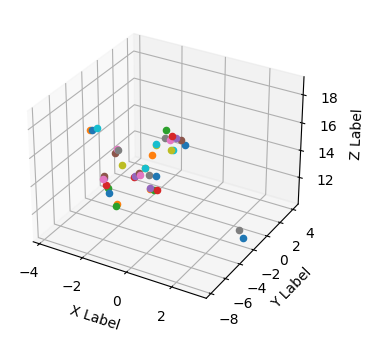

K matrix =  [[746.30680591   0.         375.11713941]
 [  0.         745.57504686 498.55608143]
 [  0.           0.           1.        ]]

R matrices =  (array([[0.00032732],
       [0.03678826],
       [0.01576595]]), array([[-0.03255708],
       [ 0.00429758],
       [-1.56684347]]), array([[-0.05709179],
       [ 0.00475645],
       [ 0.00383541]]), array([[-0.10777239],
       [ 0.01753189],
       [ 0.01025445]]), array([[-0.15182787],
       [ 0.01213292],
       [ 0.00797251]]), array([[-0.16968039],
       [ 0.01075326],
       [ 0.01435526]]), array([[-0.15169996],
       [ 0.01515416],
       [ 0.02254562]]), array([[ 0.10700515],
       [-0.01450014],
       [ 1.57570437]]), array([[ 0.06200945],
       [ 0.15640409],
       [-1.55746322]]), array([[ 0.09294521],
       [ 0.19662445],
       [-1.55518197]]), array([[ 0.20939063],
       [-0.10832509],
       [ 1.56500189]]), array([[-0.08370795],
       [ 0.04452683],
       [ 0.27250945]]), array([[-0.11514009],
       [ 0

In [1]:
# Problem 1 - Camera Callibration

# Importing packages
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Criteria for cornersSubPix() function. Stops after certain iterations,
# epsilon or accuracy is reached
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Determine the pattern size and folder with images
a = 7
b = 7
folder = "test_folder" 


def calibrateCamera(a,b,folder,debug) :

    # "create" object vertices by creating possible corners such as (0,0,0),(1,0,0), ... (5,5,0), ... (a,b,0)
    # third component is 0 since we are keeping the chessboard on a plane and are moving the camera
    possiblePoints3d = np.zeros((a*b,3), np.float32)
    possiblePoints3d[:,:2] = np.mgrid[0:a,0:b].T.reshape(-1,2)

    # Store 3D points (object) and 2D points (image)
    points3d = [] # 3d points in real world space
    points2d = [] # 2d points in image plane.

    found = 0                                                   # count the pictures read 
    images = []                                                 # store images in this array
    for filename in os.listdir(folder):
        path = os.path.join(folder,filename)                    # create path for image you want to read
        img = cv2.imread(path)                                  # read image
        
        # Downscale image because photos shot on iPhone are too big
        p = 0.25                                                # select downscaling factor                         
        new_width = int(img.shape[1] * p)                       # calculate new width
        new_height = int(img.shape[0] * p)                      # calculate new height
        img = cv2.resize(img, (new_width, new_height))          # resize
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)            # convert to gray image
        
        
        if (debug == True) :
            # Can show images for debugging/other purposes
            cv2.imshow('img',gray)
            cv2.waitKey(8000)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (a,b), None)


        # If we found corners/the pattern, add them to points3d and the image points (corners) after refining them
        if ret == True:
            found += 1 
            points3d.append(possiblePoints3d)
            corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria) # add corners after refining
            points2d.append(corners2)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (a,b), corners2, ret)
            if (debug == True) :
                cv2.imshow('img', img)
                cv2.waitKey(8000)
                debug = False
            
    cv2.destroyAllWindows()
    
    # Callibrate the camera with the set of 3D and 2D points and size of gray image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(points3d, points2d, gray.shape[::-1], None, None)
    
    print("Number of images used for calibration: ", found) # report how many pictures were used
    
    
    return ret, mtx, dist, rvecs, tvecs



def plotCameraLoc(tvecs):
    # Create plot window
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get coordinates from Tvec, obtained from calibrateCamera()
    for arrs in tvecs:
        x_coord = arrs[0]
        y_coord = arrs[1]
        z_coord = arrs[2]
        ax.scatter(x_coord,y_coord,z_coord) # add all coordinates to plot

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()


# Run actual program
ret, mtx, dist, rvecs, tvecs = calibrateCamera(a,b,folder,True)
plotCameraLoc(tvecs)

print("K matrix = ", mtx)
print("\nR matrices = ", rvecs)
print("\n T vectors = ", tvecs)



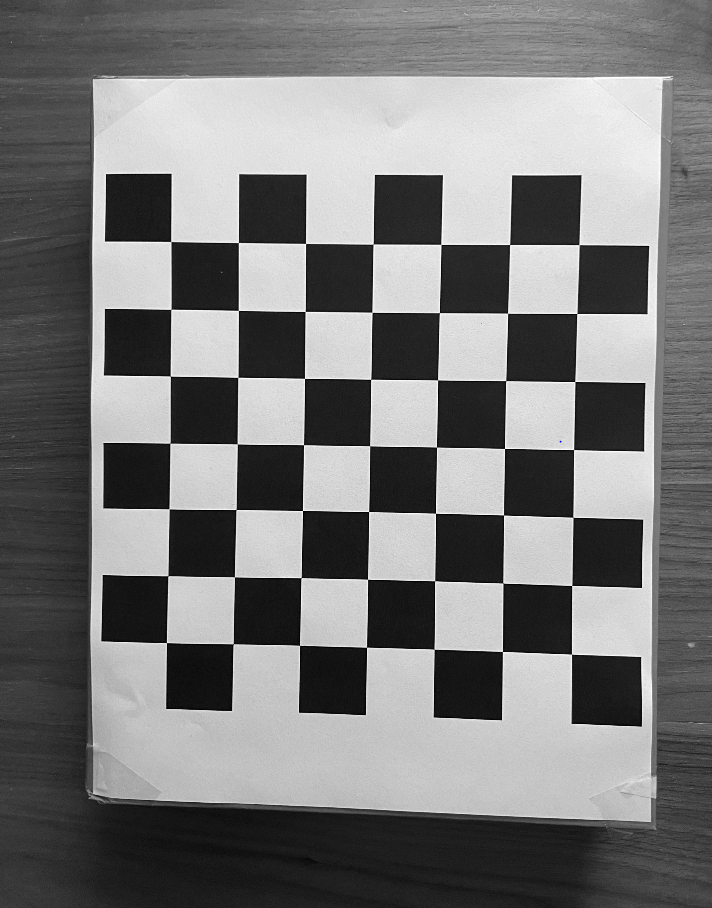

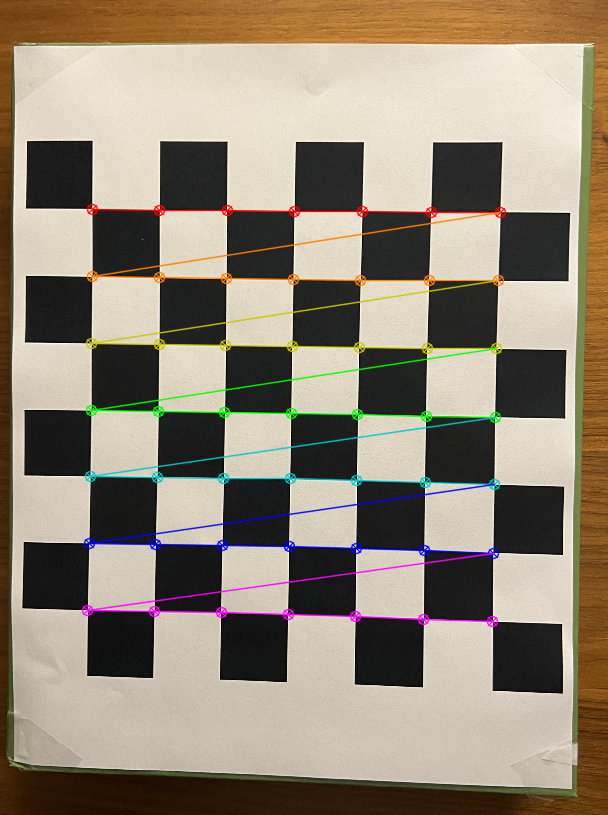

In [ ]:
# Problem 2

import numpy as np
from numpy import linalg
import scipy as scp
from scipy.linalg import svd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import math

def createCameraMatrix(Rrow1, Rrow2, Rrow3, tvec, Krow1,Krow2,Krow3):
    R_W = np.array([Rrow1,Rrow2,Rrow3])
    t_W = np.array(tvec)
    t_W = t_W.reshape((-1,1))
    T_W = np.hstack([R_W,t_W])
    K = np.array([Krow1,Krow2,Krow3])
    M = np.dot(K,T_W)
    
    return M, K, T_W, R_W, t_W

def MdotPoints(points,matrix,output):
    for point in points:
        temp = np.dot(matrix,point)
        output.append(temp/(temp[2]))

def pixelTo2D(point,sigma_x,sigma_y,sx,sy,focal_length):
    newx = (point[0]-sigma_x) * (-sx)
    newy = (point[1] - sigma_y) * (-sy)
    return np.array([newx,newy,focal_length])

def createTwX(matrix):
    return np.vstack([matrix, [0,0,0,1]])


def solveRayEqs(pl,pr,RrL,trL):
    q = np.cross(pl, np.dot(RrL,pr))
    lenq = math.sqrt(pow(q[0],2) + pow(q[1],2) + pow(q[2],2))
    q = q/lenq
    alpha = - np.dot(RrL, pr)
    mtx = np.array([pl, alpha,q]).T
    # s, v, d = np.linalg.svd(mtx)
    a,b,c = np.linalg.solve(mtx,trL)
    return a,b,c,q

def calculatePW (pl,a,c,q,TwL):
    PL = a * pl + (c/2) * q
    PL = np.hstack([PL,[1]]).T
    print(PL)
    PW = np.dot(np.linalg.inv(TwL),PL)
    return PW, PL

# K matrix & its parameters
Krow1 = [-100,0,200]
Krow2 = [-0,-100,200]
Krow3 = [0,0,1]
sigma_x = Krow1[2]
sigma_y = Krow2[2]
focal_length = 100
sx = -focal_length/Krow1[0]
sy = -focal_length/Krow2[1]



# Parameters for Left Camera
R1_row1 = [0.707,0.707,0]
R1_row2 = [-0.707,0.707,0]
R1_row3 = [0,0,1]
t1_vec = [-3,-0.5,3]

M1,K,T1,R1,t1 = createCameraMatrix(R1_row1, R1_row2,R1_row3,t1_vec,Krow1,Krow2,Krow3)


# Parameters for Right Camera
R2_row1 = [0.866,-0.5,0]
R2_row2 = [0.5,0.866,0]
R2_row3 = [0,0,1]
t2_vec = [-3,-0.5,3]

M2,K,T2,R2,t2 = createCameraMatrix(R2_row1, R2_row2,R2_row3,t2_vec,Krow1,Krow2,Krow3)


# Creating a cube, defining the points in world-coord.
p0 = np.array([0,0,0,1])
p1 = np.array([1,0,0,1])
p2 = np.array([0,0,1,1])
p3 = np.array([1,0,1,1])
p4 = np.array([0,1,1,1])
p5 = np.array([1,1,1,1])
p6 = np.array([0,1,0,1])
p7 = np.array([1,1,0,1])

points_3d = [p0,p1,p2,p3,p4,p5,p6,p7]


# Going from 3d to 2d, to image coords.
pointsFromFirst  = []  # store all M1 * points_3D
pointsFromSecond = []  # store all M2 * points_3D

# Multiply every point in the cube with each matrix and store them
MdotPoints(points_3d,M1,pointsFromFirst)
MdotPoints(points_3d,M2,pointsFromSecond)


pl_0 = pixelTo2D(pointsFromFirst[0],sigma_x,sigma_y,sx,sy,focal_length)
pr_0 = pixelTo2D(pointsFromSecond[0],sigma_x,sigma_y,sx,sy,focal_length)



TwL = createTwX(T1)         # create T_w^L, for left camera
TwR = createTwX(T2)         # create T_w^R, for right camera
TrW = np.linalg.inv(TwR)    # invert T_w^R to get T_r^W


TrL = np.dot(TwL,TrW)       # combine both to get TrL
RrL = TrL[0:3,0:3]          # extract RrL
trL = TrL[0:3,3]            # extract trL

# s,v,d = solveRayEqs(pl_0,pr_0,RrL,trL)
# x = d*(diag(diag(v).^-1)*(s.'*b))
# print(s)
# print("\n",v.T)
# print("\n",d)

a,b,c,q = solveRayEqs(pl_0,pr_0,RrL,trL)

print(a,b,c,q)

pw,pl = calculatePW(pl_0,a,c,q,TwL)

print(pw)